In [17]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = [7,5]

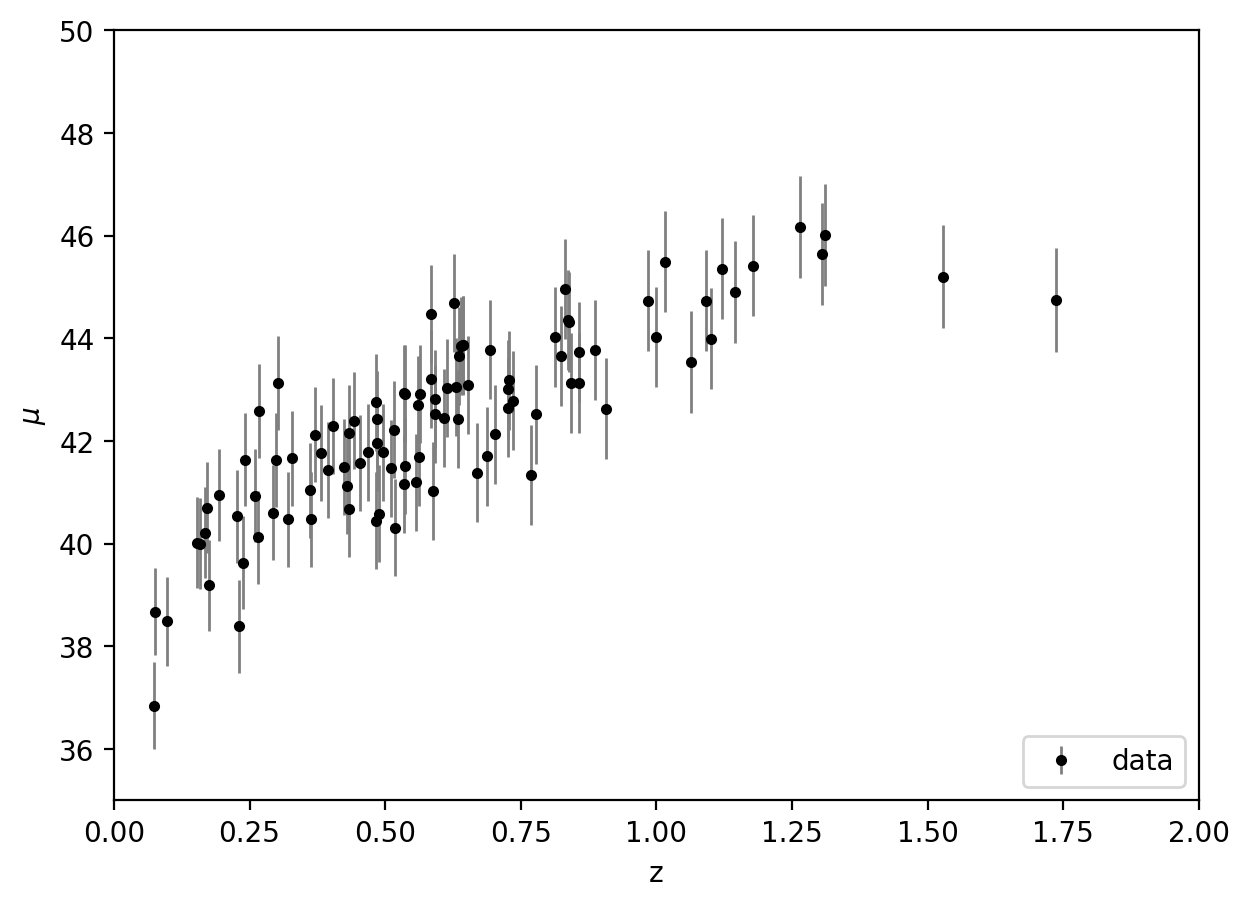

In [18]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
N=len(z_sample)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

x=z_sample.copy()[:,np.newaxis]
y=mu_sample.copy()
dy=dmu.copy()

### Linear Regression

The parameters are: 

Theta0 = 39.60456481105869
Theta1 = 4.591193304500258


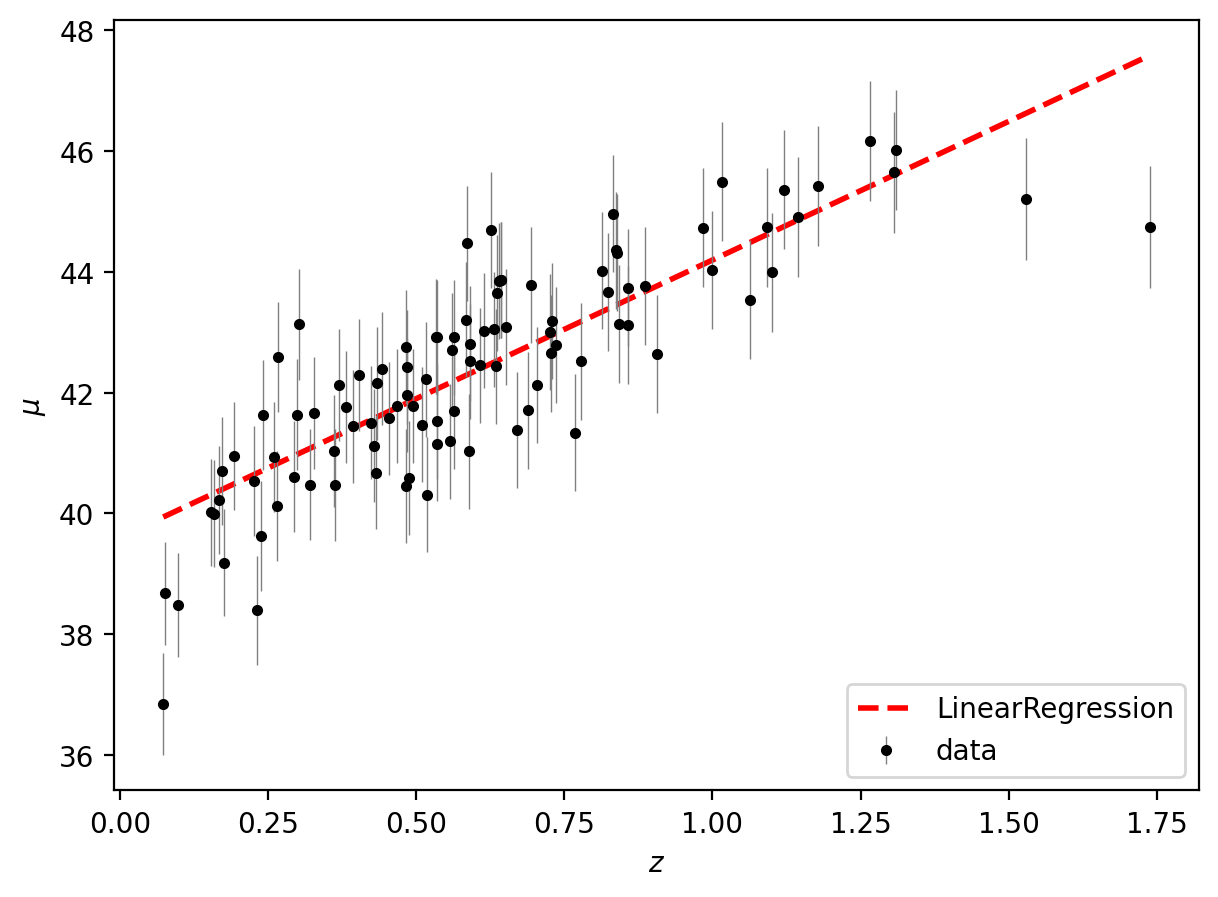

In [19]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x, y, sample_weight=dy)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_
print('The parameters are: \n')
print('Theta0 =',theta0.item())
print('Theta1 =',theta1.item())

x_grid=np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred = lin_reg.predict(x_grid)

plt.plot(x_grid, y_pred, "r--", linewidth=2, label="LinearRegression")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend(loc="lower right")
plt.show()

### Polynomial Regression

In [20]:
def poly_regression(X,Y,err,d):
    x_grid=np.linspace(min(X[:,0]),max(X[:,0]),1000)[:, np.newaxis]
    model = PolynomialRegression(d)
    model.fit(X, Y, err)
    y_pred = model.predict(x_grid)
    plt.plot(x_grid, y_pred,alpha=0.8,label = 'degree = %i'%d)

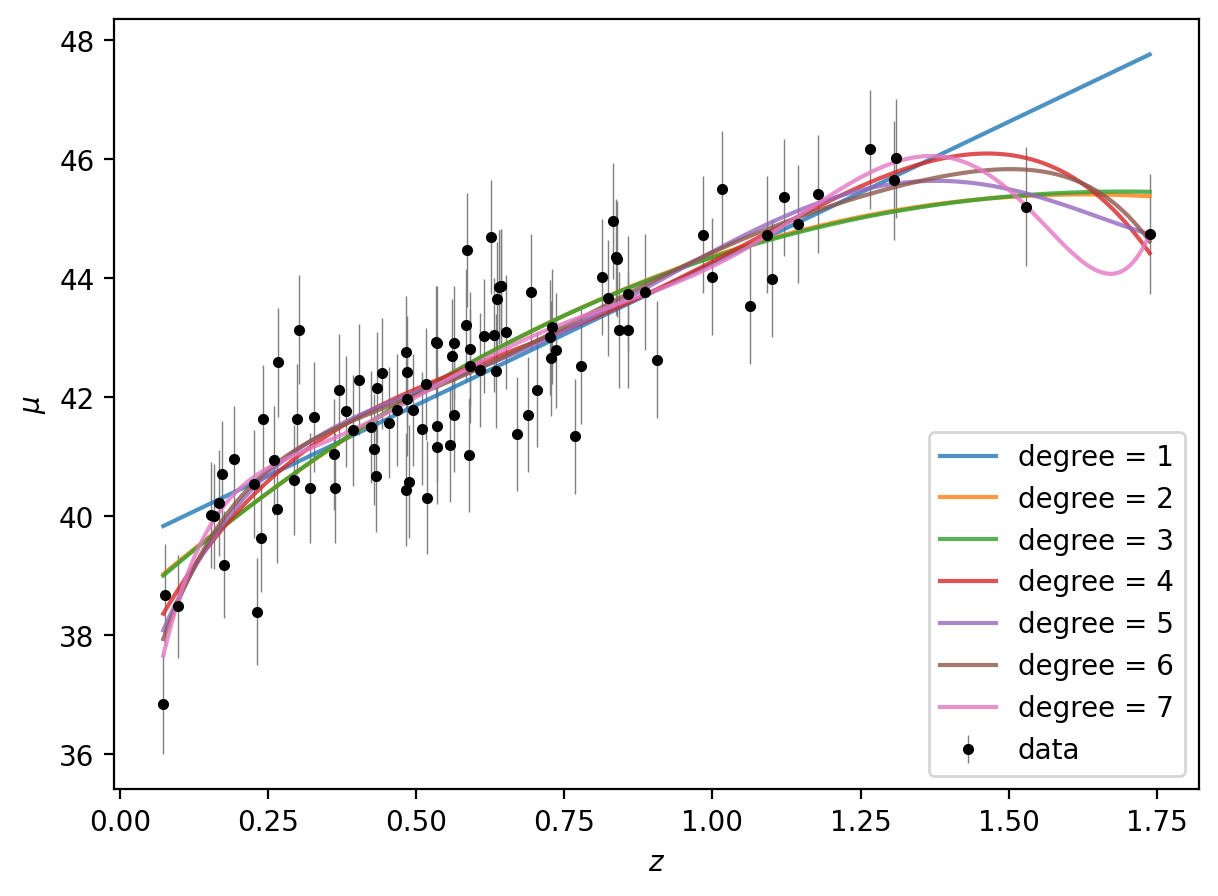

In [21]:
from astroML.linear_model import PolynomialRegression

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5, label='data')
for d in [1,2,3,4,5,6,7]:
    poly_regression(x,y,dy,d)
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend(loc="lower right")
plt.show()

From the plot above one can sees that by changing the degree the model curve is similar in the central region, where there are more data, while it changes significantly at high values of z: the higher the degree, the more the model follows these last points, up to the overfit for degree = 7.

### Cross validation

Firstly I do a simple cross-validation test keeping fixed the points in the cross-validation - whose size is the 30% of the total set. I compute the training error and the cross-validation error.

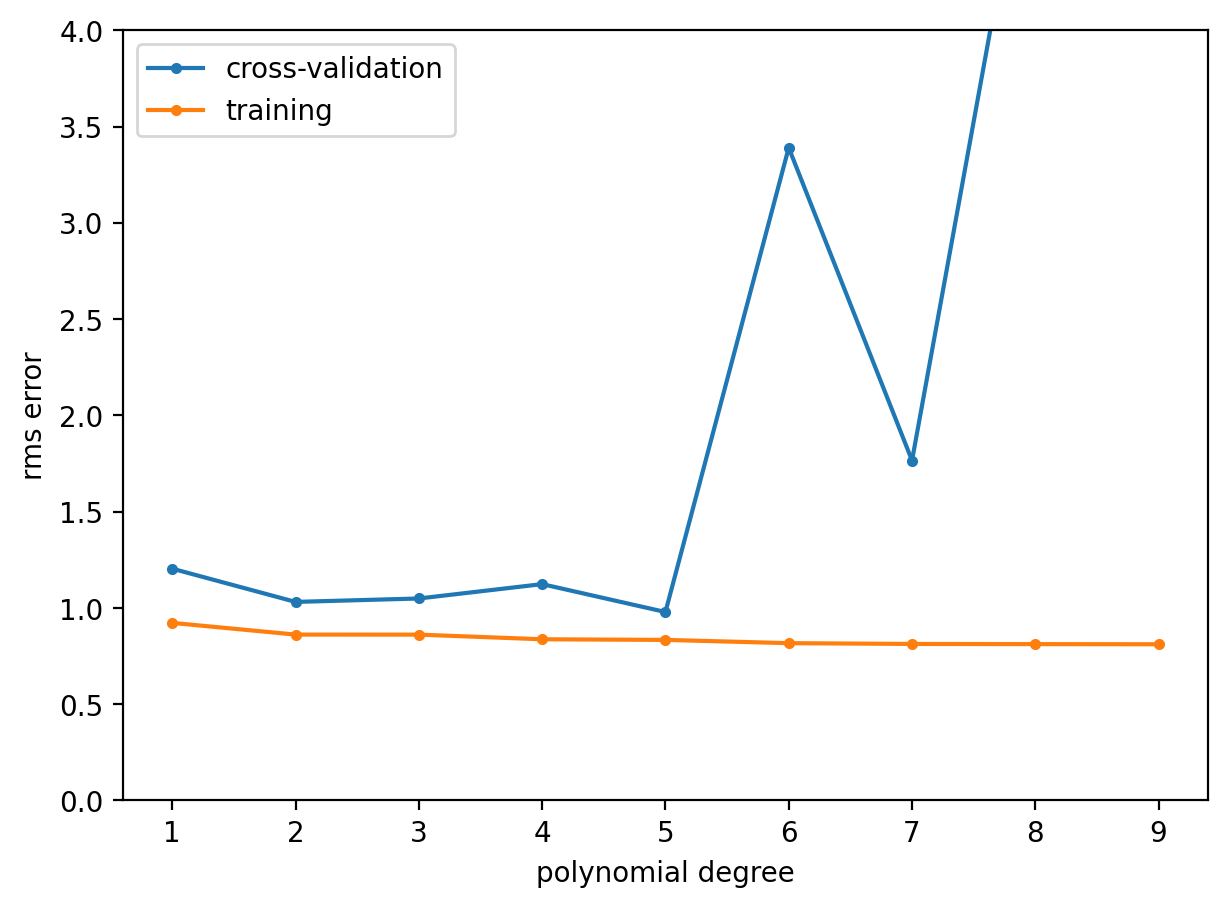

Best degree:  5
cross-validation error:  0.978840366863215


In [22]:
degrees = np.arange(1,10)
np.random.seed(42)
cv = np.random.randint(len(x), size=int(0.3*len(x)))
x_cv=x[cv]
y_cv=y[cv]
dy_cv=dy[cv]
x_train = np.delete(x,cv,axis=0)
y_train = np.delete(y,cv,axis=0)
dy_train = np.delete(dy,cv,axis=0)

training_err = np.zeros(degrees.shape)
crossval_err = np.zeros(degrees.shape)
for i,d in enumerate(degrees):
    model = PolynomialRegression(d)
    model.fit(x_train, y_train, dy_train)
    training_err[i] = np.sqrt(np.sum((model.predict(x_train) - y_train) ** 2)/len(y_train))
    crossval_err[i] = np.sqrt(np.sum((model.predict(x_cv) - y_cv)**2)/ len(y_cv))

plt.plot(degrees, crossval_err, '.-', label='cross-validation')
plt.plot(degrees, training_err, '.-', label='training')

plt.xlabel('polynomial degree')
plt.ylabel('rms error')
plt.legend()
plt.ylim(0,4)
plt.show()

print('Best degree: ',degrees[np.argmin(crossval_err)])
print('cross-validation error: ',min(crossval_err))

I want to be sure that the size of the training set is right, so I plot the learning curves for each model

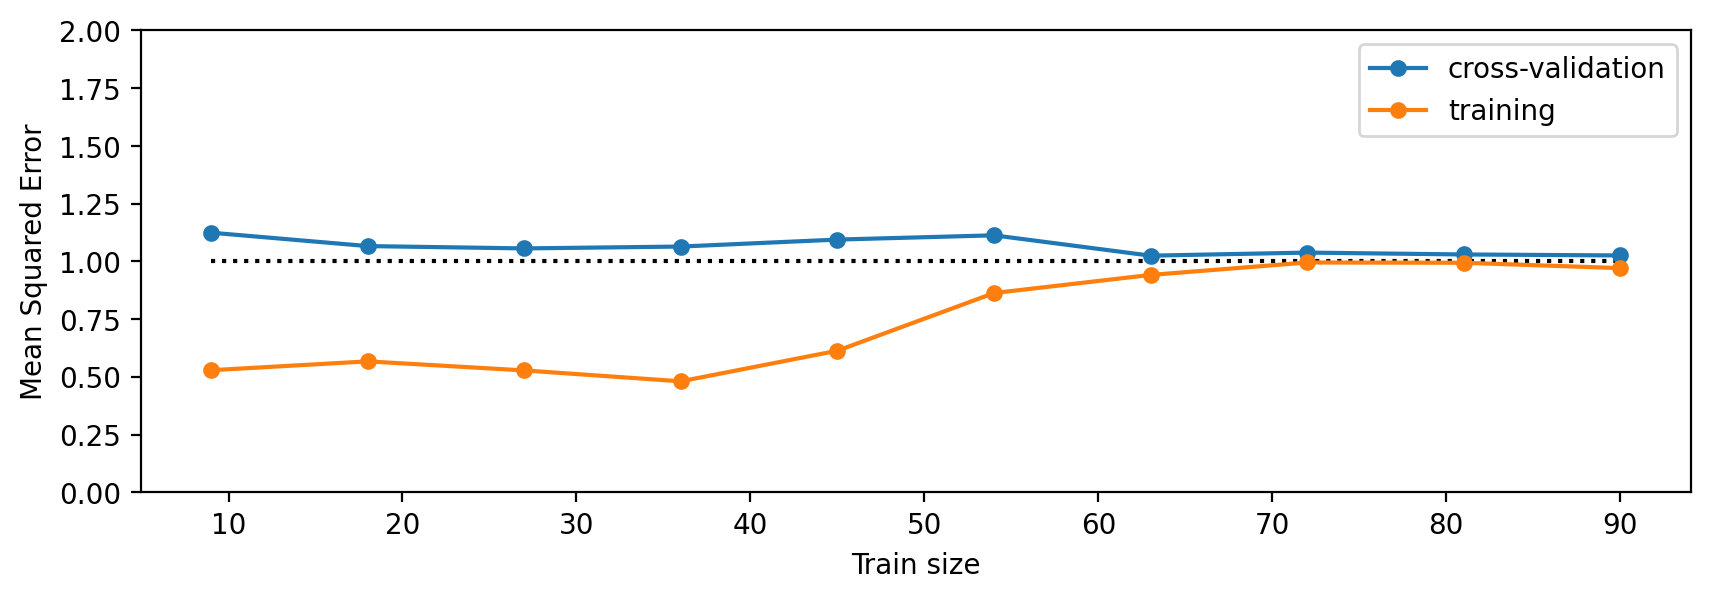

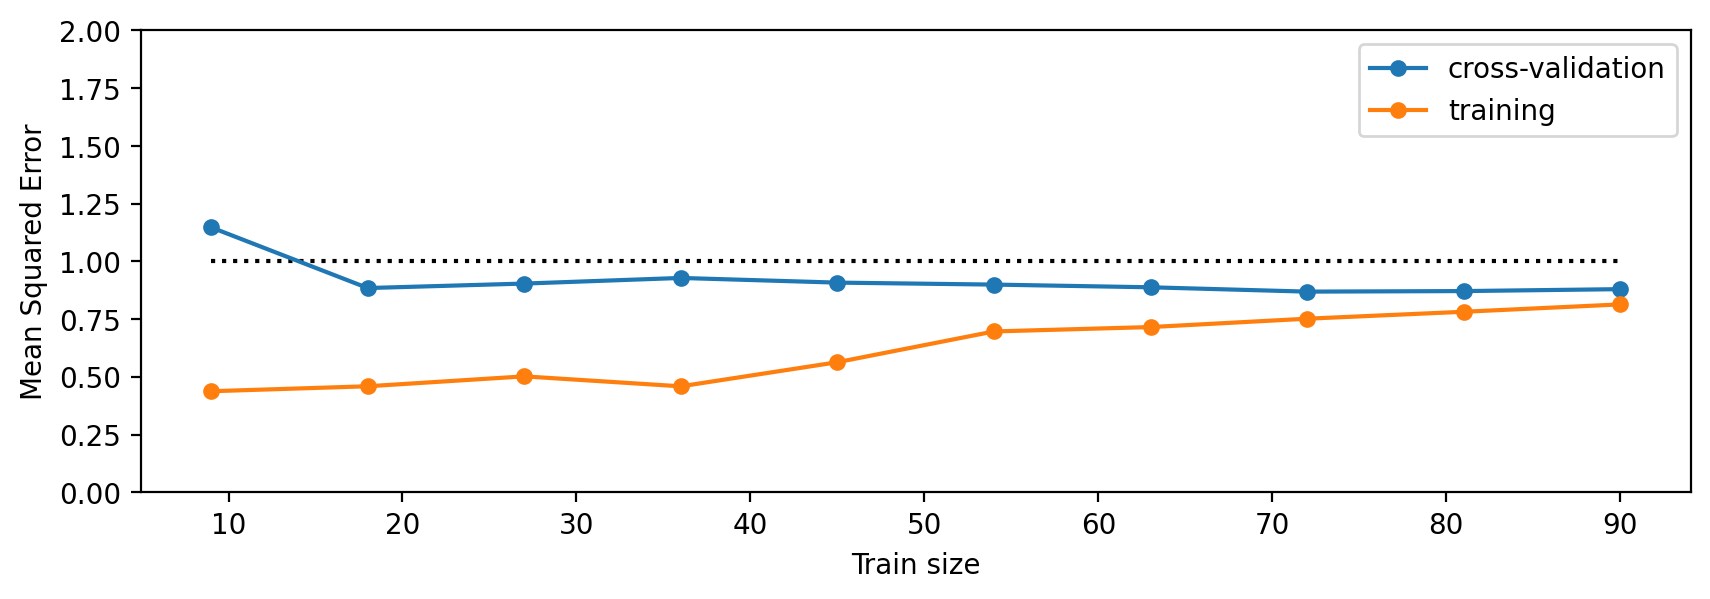

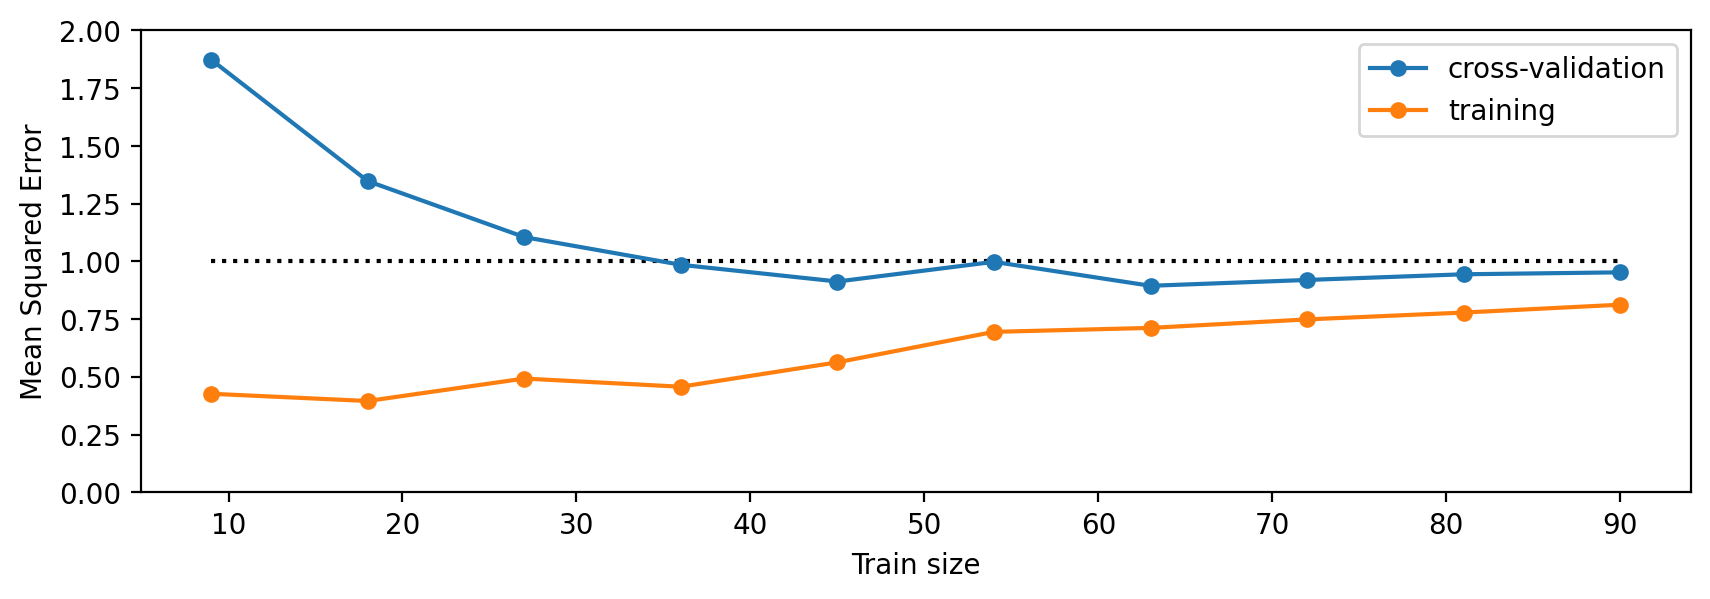

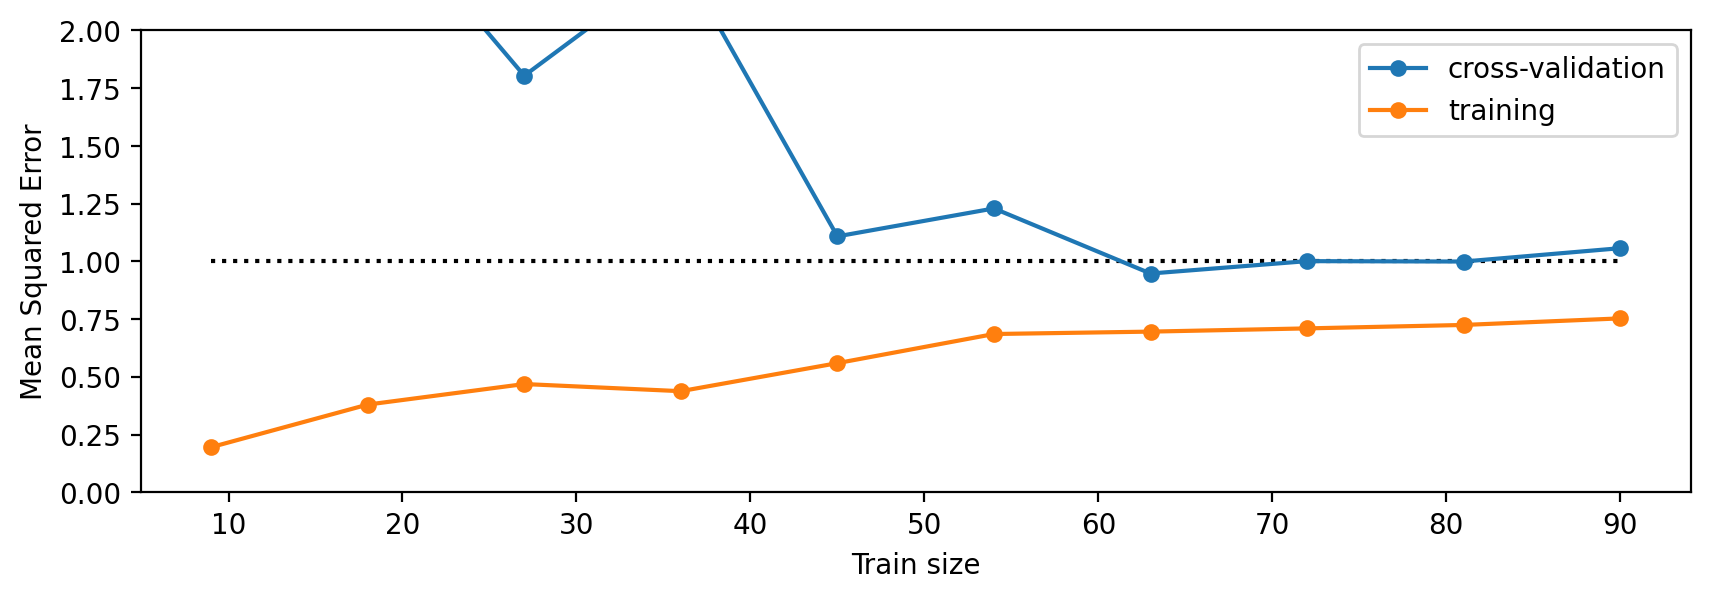

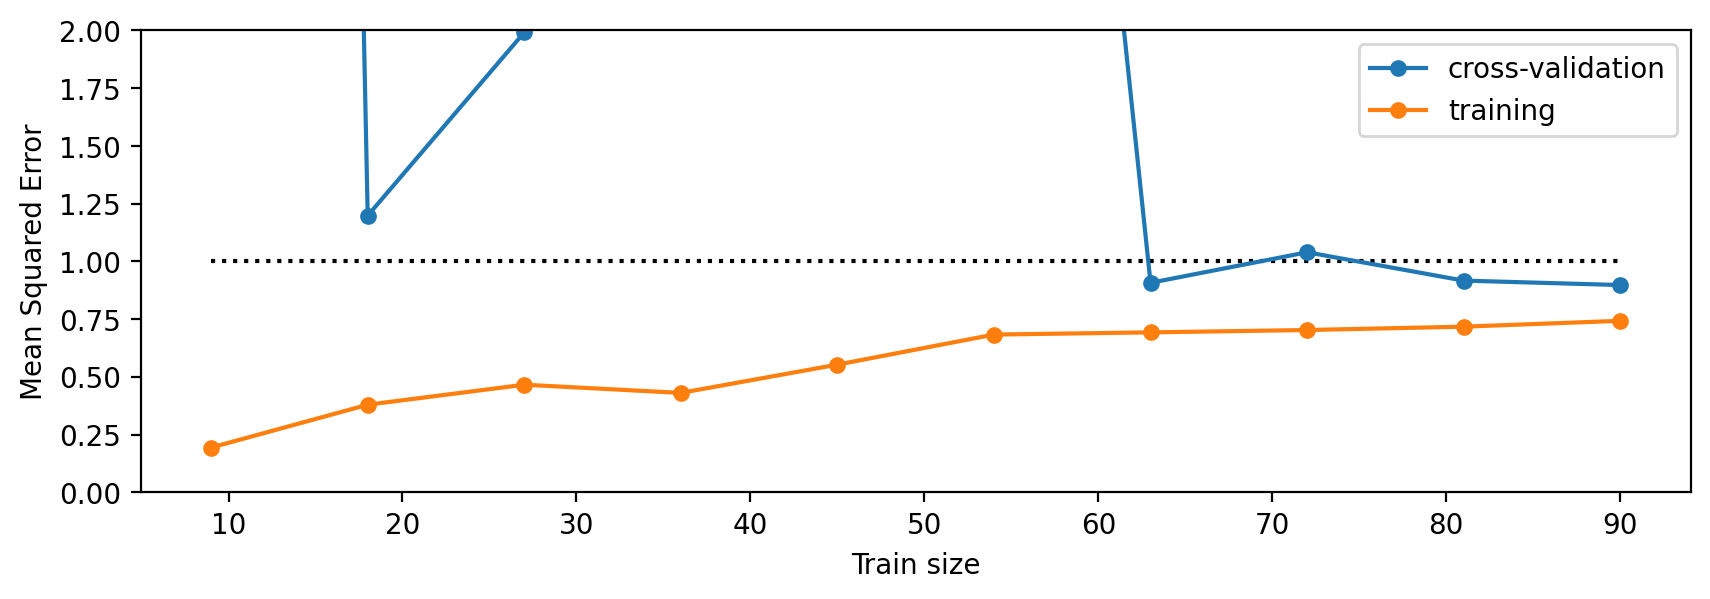

In [23]:
from sklearn.model_selection import learning_curve
for d in degrees[:5]:
    model = PolynomialRegression(d)
    train_sizes, train_scores_linreg, test_scores_linreg = learning_curve(model, x, y, train_sizes=np.linspace(0.1, 1, 10),
                                                                      scoring="neg_mean_squared_error", cv=10, 
                                                                      fit_params={'y_error':dy})
    
    fig = plt.figure(figsize=(10,3))
    plt.hlines(1,min(train_sizes),max(train_sizes),colors='k', linestyle=':')              
    plt.plot(train_sizes, -test_scores_linreg.mean(1), 'o-', markersize=5, label="cross-validation")
    plt.plot(train_sizes, -train_scores_linreg.mean(1), 'o-', markersize=5,label="training")
    plt.xlabel("Train size")
    plt.ylabel("Mean Squared Error")
    plt.ylim(0,2)
    plt.legend()

From these curves I learn that I'm in the regime where the two errors are converging.
Since the result of the CV test can depend on which points are in the training set, I split the dataset in 4 sets and each time I consider one of this set as the CV set and the other three as three training set

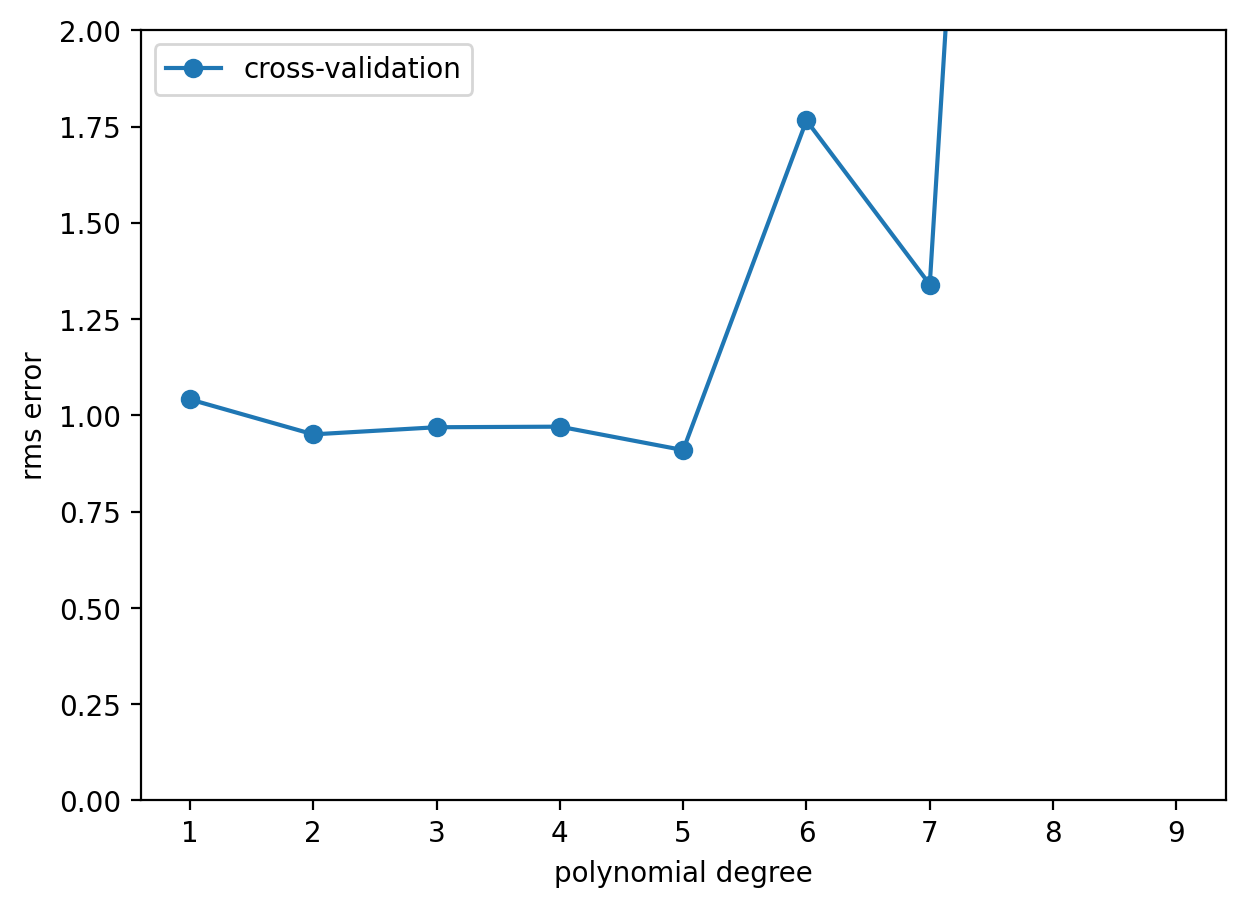

Best degree:  5
cross-validation error:  0.9100279098055303


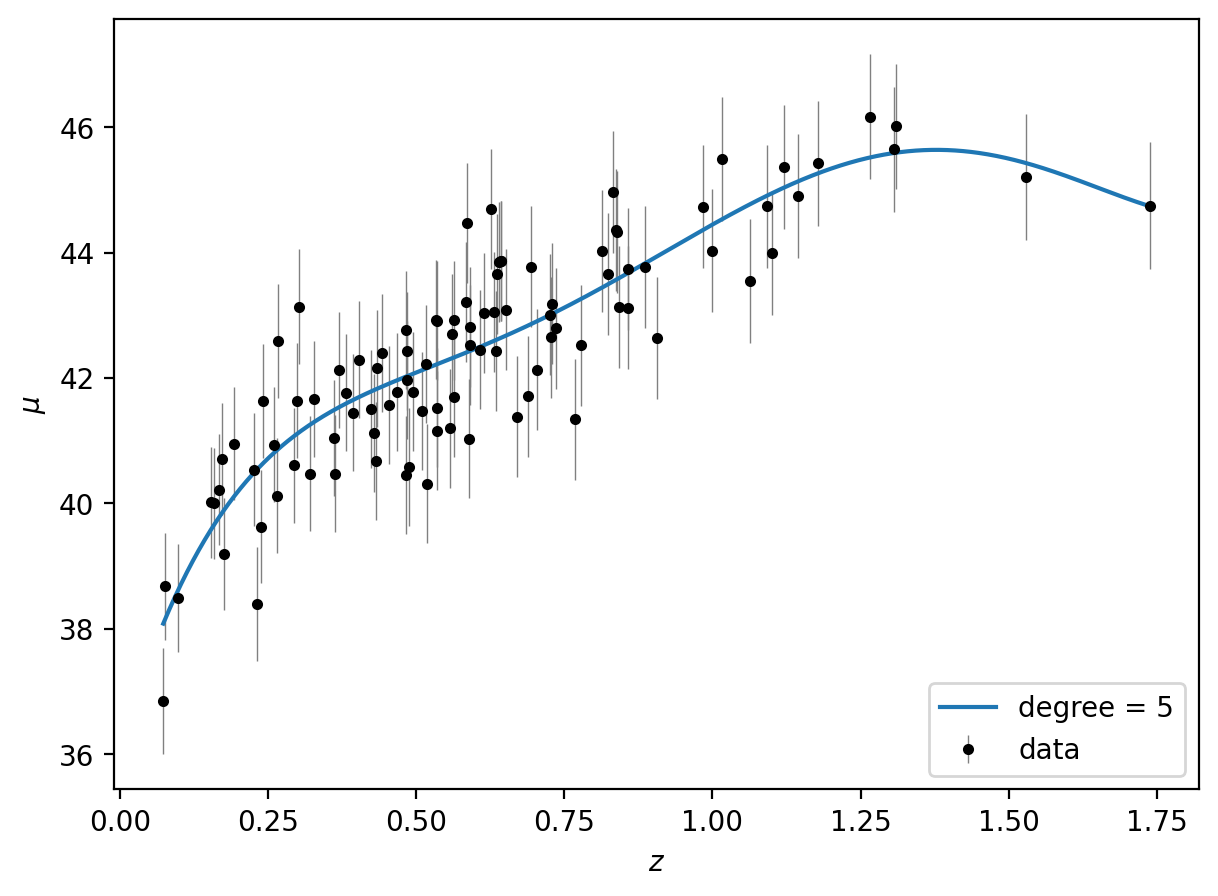

In [24]:
np.random.seed(42)
cv_err = np.zeros(len(degrees))
ind = np.arange(len(x),dtype=int)
np.random.shuffle(ind)
train = np.split(ind, 4)

for i,d in enumerate(degrees):
    cv_dist=np.array([])
    for cv in train:
        x_cv=x[cv]
        y_cv=y[cv]
        dy_cv=dy[cv]

        x_train = np.delete(x,cv,axis=0)
        y_train = np.delete(y,cv,axis=0)
        dy_train = np.delete(dy,cv,axis=0)
        
        model = PolynomialRegression(d)
        model.fit(x_train, y_train, dy_train)
        dist = np.sum((model.predict(x_cv) - y_cv)**2)
        cv_dist = np.append(cv_dist,dist)
    cv_err[i] = np.sqrt(np.sum(cv_dist)/len(y))
plt.plot(degrees, cv_err, 'o-', label='cross-validation')
plt.xlabel('polynomial degree')
plt.ylabel('rms error')
plt.ylim(0,2)
plt.legend()
plt.show()

d_best=degrees[np.argmin(cv_err)]
print('Best degree: ',d_best)
print('cross-validation error: ',min(cv_err))

model = PolynomialRegression(d_best)
model.fit(x, y, dy)

x_grid = np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred = model.predict(x_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.plot(x_grid, y_pred,  label = 'degree = %i'%d_best)
plt.legend(loc="lower right")
plt.show()

Even changing the cross-validation set the best degree remains 5

## Basis function regression

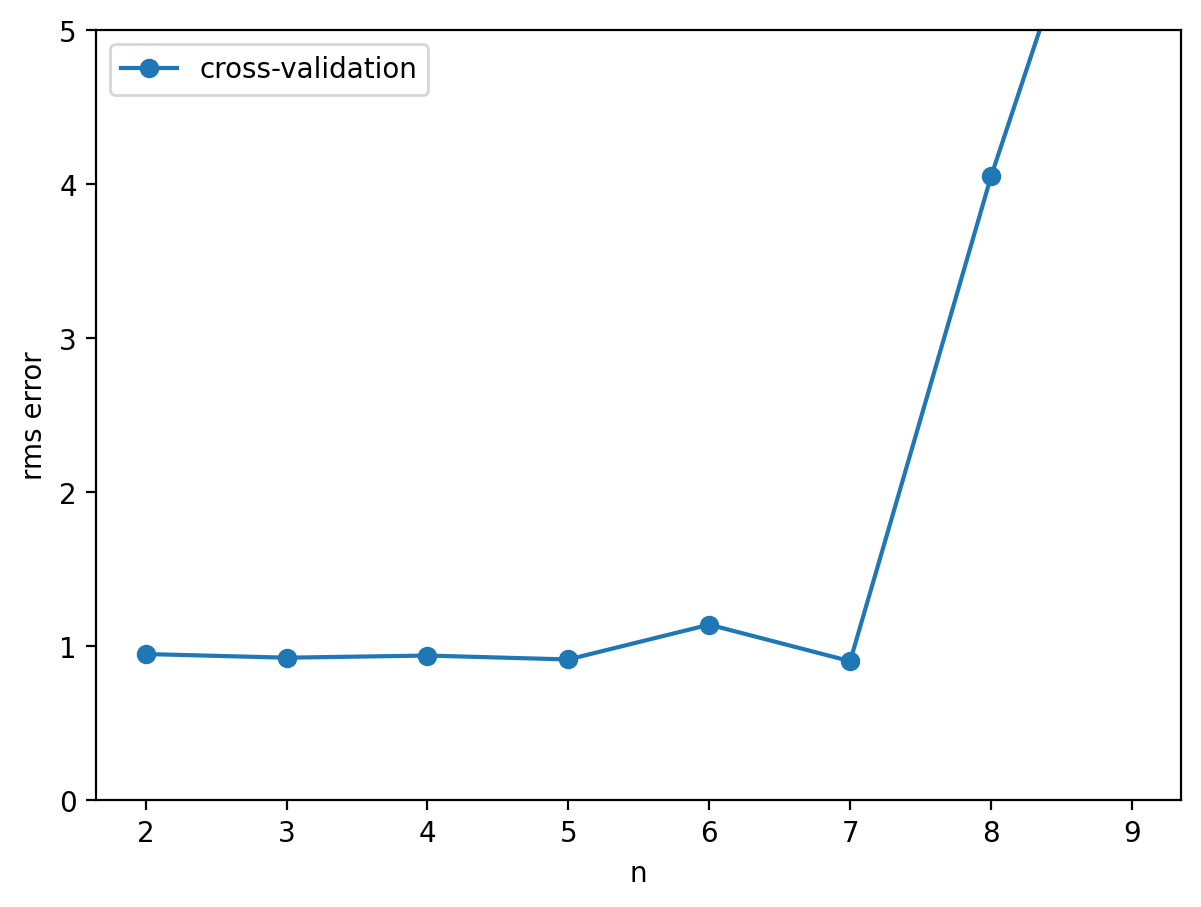

Best number of terms :  7
cross-validation error :  0.9041863875130599


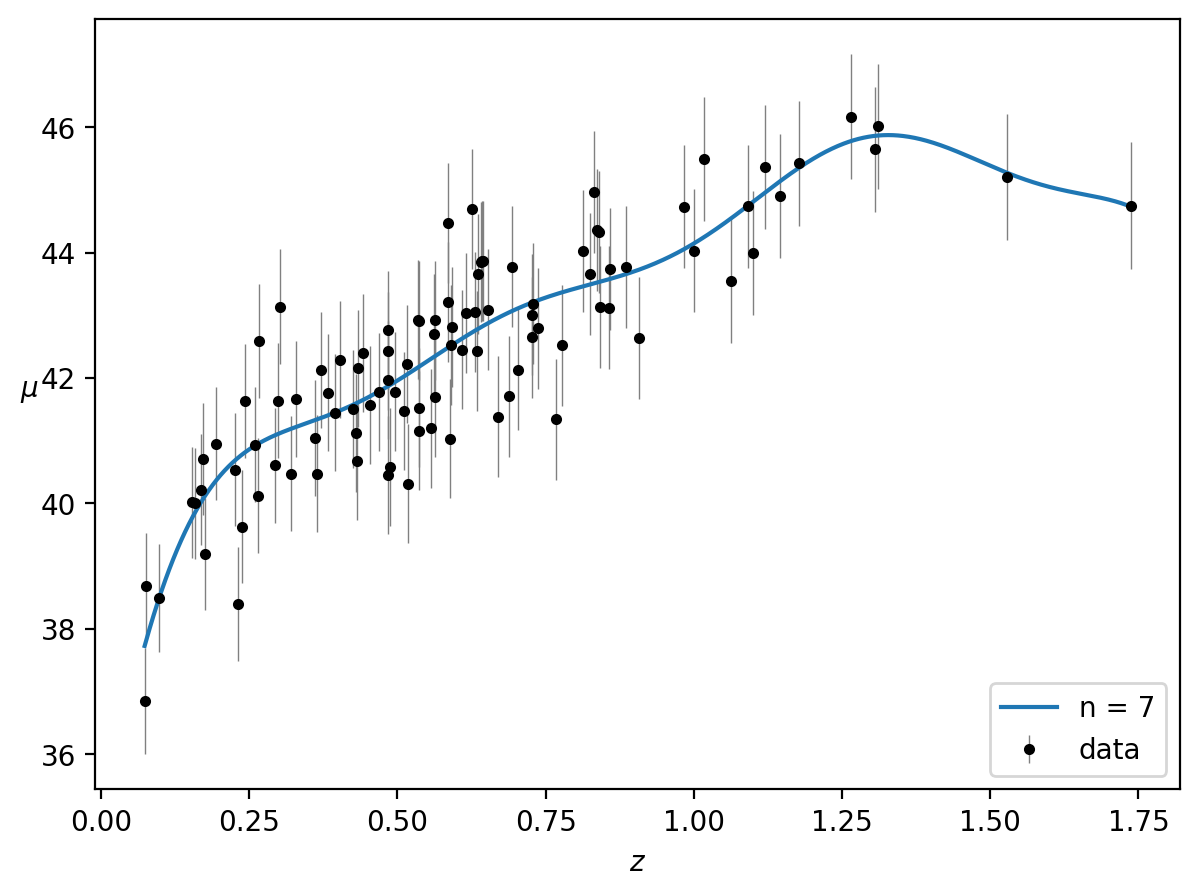

In [25]:
from astroML.linear_model import BasisFunctionRegression
np.random.seed(42)
n = np.arange(2,10)
cv_err = np.zeros(len(n))
for i,N in enumerate(n):
    cv_dist=np.array([])
    for cv in train:
        x_cv=x[cv]
        y_cv=y[cv]
        dy_cv=dy[cv]

        x_train = np.delete(x,cv,axis=0)
        y_train = np.delete(y,cv,axis=0)
        dy_train = np.delete(dy,cv,axis=0)
        mu_grid = np.linspace(0,2,N)[:,np.newaxis]
        sigma = mu_grid[1]-mu_grid[0]
        model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma)
        model.fit(x_train, y_train, dy_train)
        dist = np.sum((model.predict(x_cv) - y_cv)**2)
        cv_dist = np.append(cv_dist,dist)
    cv_err[i] = np.sqrt(np.sum(cv_dist)/len(y))
plt.plot(n, cv_err, 'o-', label='cross-validation')
plt.ylim(0,5)
plt.xlabel('n')
plt.ylabel('rms error')
plt.legend()
plt.show()
n_best=n[np.argmin(cv_err)]
print('Best number of terms : ',n_best)
print('cross-validation error : ',min(cv_err))

mu_grid = np.linspace(0,2,n_best)[:,np.newaxis]
sigma = mu_grid[1]-mu_grid[0]
model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma)
model.fit(x, y, dy)

x_grid = np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred = model.predict(x_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
plt.xlabel("$z$")
plt.ylabel("$\mu$", rotation=0)
plt.plot(x_grid, y_pred,  label = 'n = %i'%n_best)
plt.legend(loc="lower right")
plt.show()

## Kernel regression

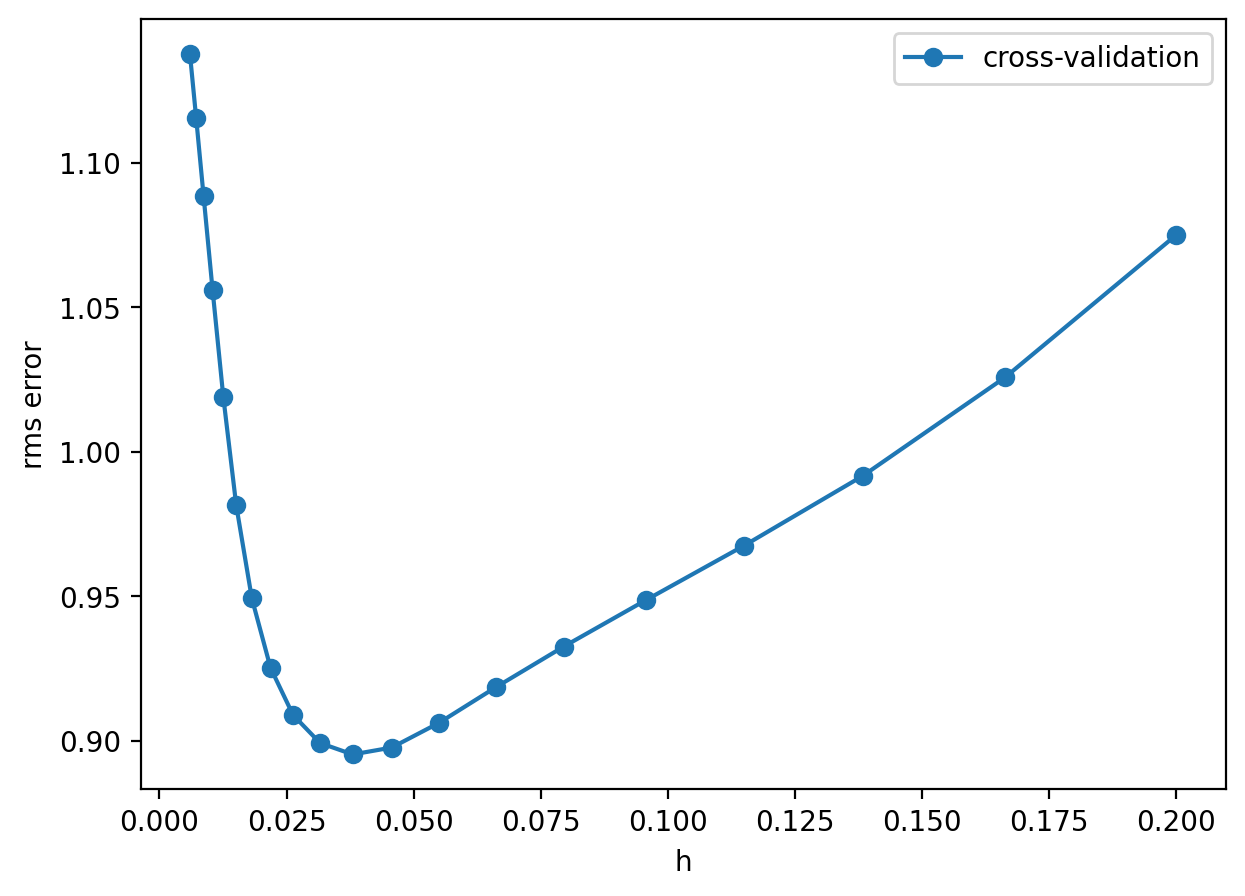

Best bandwidth :  0.03798974509143774
cross-validation error :  0.895274994924226


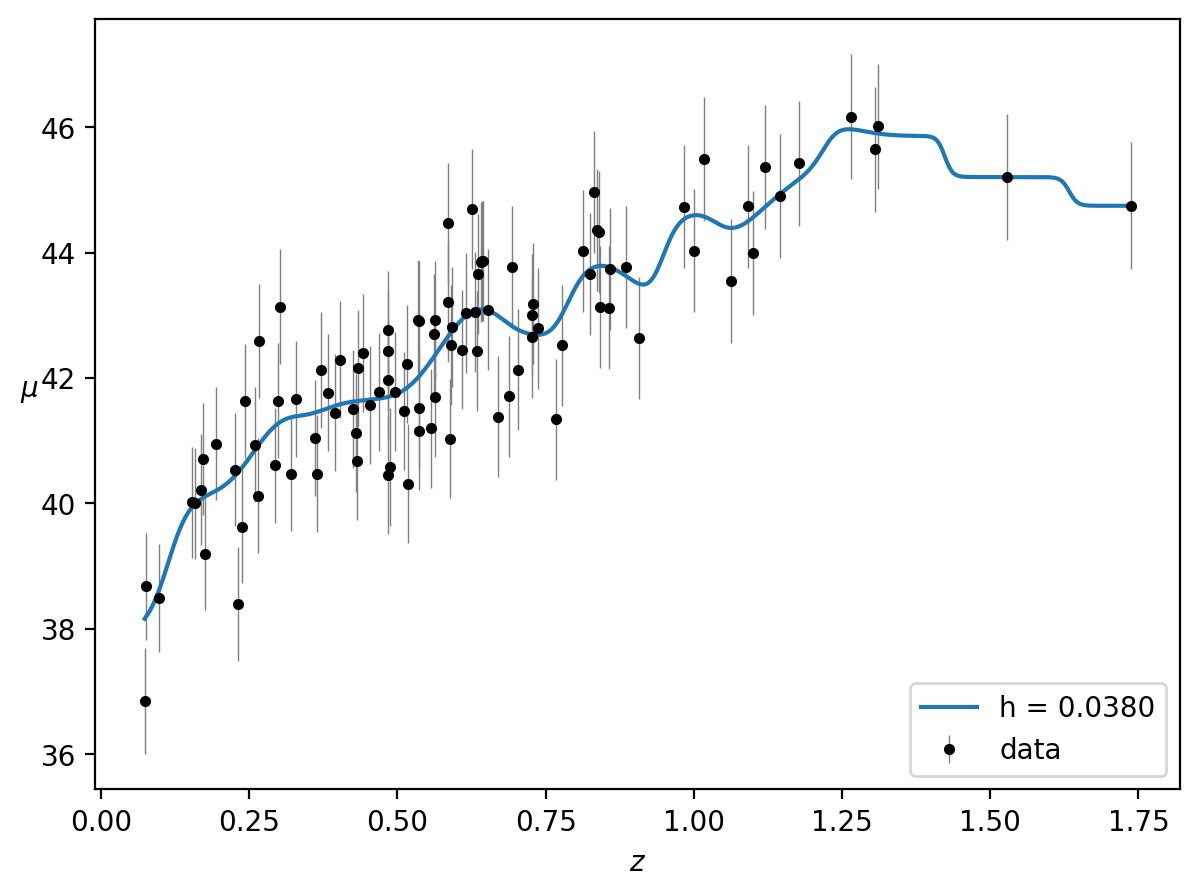

In [26]:
from astroML.linear_model import NadarayaWatson
np.random.seed(42)
h = np.geomspace(0.006,0.2,20)
cv_err = np.zeros(len(h))
for i,H in enumerate(h):
    cv_dist=np.array([])
    for cv in train:
        x_cv=x[cv]
        y_cv=y[cv]
        dy_cv=dy[cv]

        x_train = np.delete(x,cv,axis=0)
        y_train = np.delete(y,cv,axis=0)
        dy_train = np.delete(dy,cv,axis=0)

        model = NadarayaWatson(kernel='gaussian', h=H)
        model.fit(x_train, y_train, dy_train)
        dist = np.sum((model.predict(x_cv) - y_cv)**2)
        cv_dist = np.append(cv_dist,dist)
    cv_err[i] = np.sqrt(np.sum(cv_dist)/len(y))
plt.plot(h, cv_err, 'o-', label='cross-validation')
plt.xlabel('h')
plt.ylabel('rms error')
plt.legend()
plt.show()
h_best=h[np.argmin(cv_err)]
print('Best bandwidth : ',h_best)
print('cross-validation error : ',min(cv_err))

model = NadarayaWatson(kernel='gaussian', h=h_best)
model.fit(x, y, dy)

x_grid = np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred = model.predict(x_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
plt.xlabel("$z$")
plt.ylabel("$\mu$", rotation=0)
plt.plot(x_grid, y_pred,  label = 'h = %.4f'%h_best)
plt.legend(loc="lower right")
plt.show()